In [1]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error
import gc
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-white')
%matplotlib inline

In [2]:
housing = pd.read_csv('CA housing prices.csv')

In [3]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


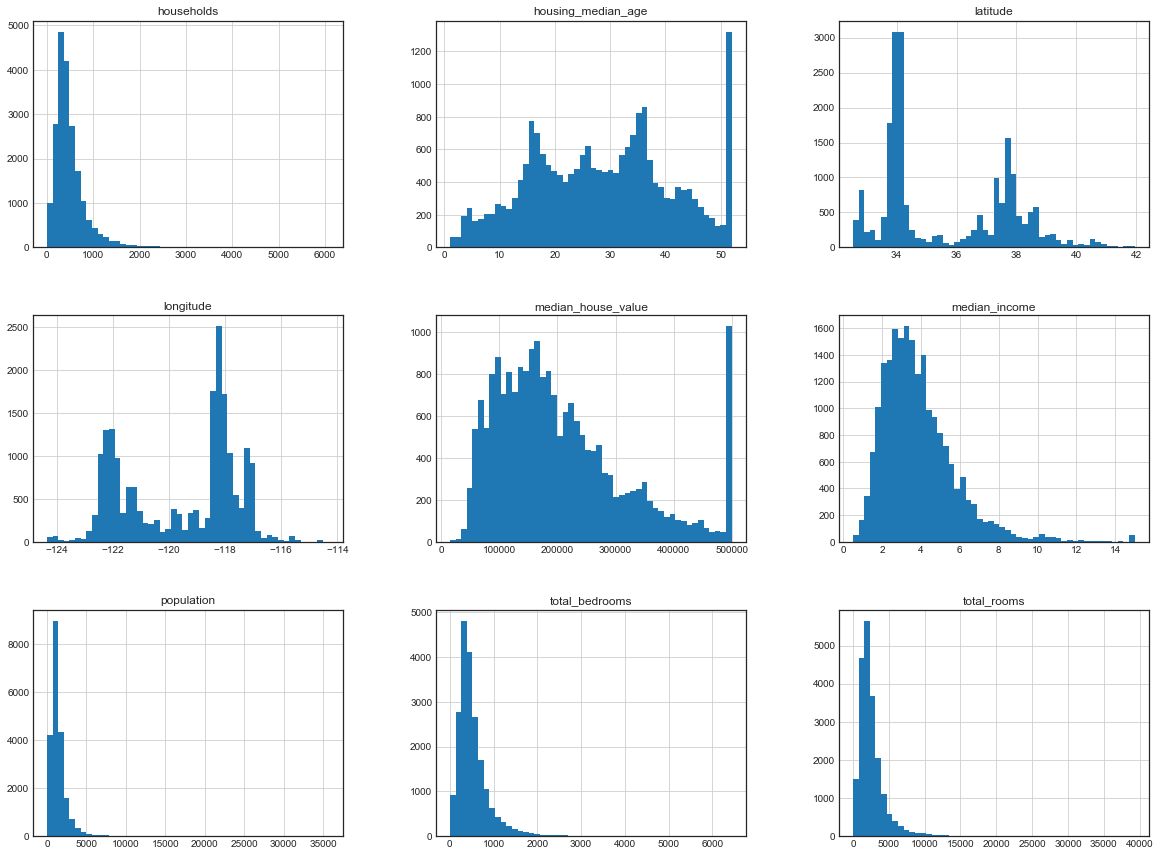

In [5]:
housing.hist(bins = 50,figsize= (20,15))
plt.show()

In [6]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

#### Median income is the most influential parameter. Negative correlation with location implies as we go north, housing prices go down
#### Before proceeding further, lets separate the test set

In [7]:
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

In [8]:
from sklearn.model_selection import train_test_split
housing_train, housing_test = train_test_split(housing, stratify = housing['income_cat'], test_size = 0.2)

In [9]:
housing_train = housing_train.drop('income_cat', axis = 1)
housing_test = housing_test.drop('income_cat', axis = 1)

#### Stratified splitting of the housing data on the basis of median income

### EDA on the training data

Text(0.5,1,'Median Income w.r.t to population & location')

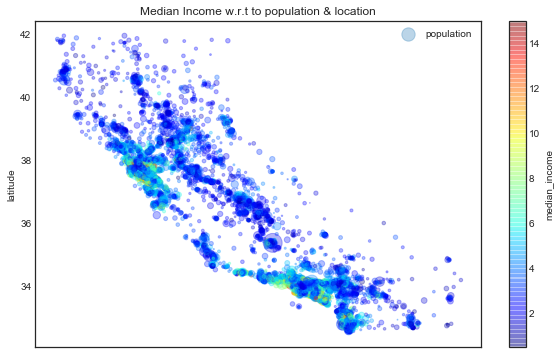

In [10]:
housing_train.plot(kind = 'scatter', x = 'longitude', y = 'latitude', alpha = 0.3, c = 'median_income',
             cmap = plt.get_cmap('jet'), s = housing['population']/100, label = 'population', figsize= (10,6))
plt.title("Median Income w.r.t to population & location")

#### median_income is generally higher for the region along the coastline 

Text(0.5,1,'Median Housing Prices with population and location')

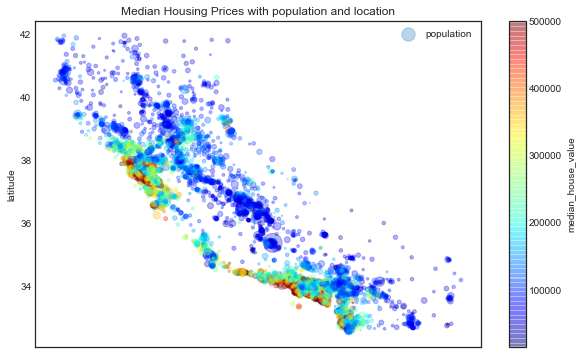

In [11]:
housing_train.plot(kind = 'scatter', x = 'longitude', y = 'latitude', alpha = 0.3, c = 'median_house_value',
             cmap = plt.get_cmap('jet'), s = housing['population']/100, label = 'population', figsize= (10,6) )
plt.title("Median Housing Prices with population and location")

#### The median housing prices is significantly higher for the region along the coastline

In [12]:
def attribute_add(df):
    df['rooms_per_household'] = df['total_rooms']/df['households']
    df['bedromms_per_room'] = df['total_bedrooms']/df['total_rooms']
    df["population_per_household"] = df["population"]/df["households"]
    return df

In [13]:
def imputation(df):
    df_num = df.drop(['ocean_proximity','median_house_value'], axis = 1)
    imputer= Imputer(strategy = 'median')
    housing_impute = pd.DataFrame(imputer.fit_transform(df_num), columns= df_num.columns)
    return housing_impute

In [14]:
housing_train_im = imputation(housing_train)
housing_train_add = attribute_add(housing_train_im)

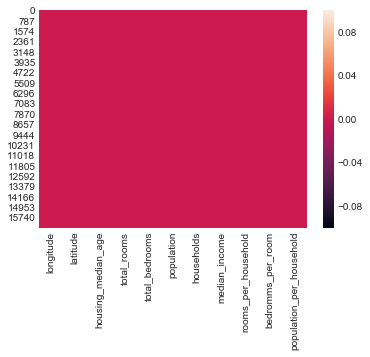

In [15]:
sns.heatmap(housing_train_add.isnull())

#### No null values. If had any, they have been imputed

#### Categorical features to numerical 

In [16]:
def binarizer(df):
    df_cat = df['ocean_proximity']
    encoder = LabelBinarizer()
    df_encoded = encoder.fit_transform(df_cat)
    return df_encoded

In [17]:
housing_train_cat = pd.DataFrame(binarizer(housing_train), columns= housing_train['ocean_proximity'].value_counts().index)

In [18]:
housing_train_cat.head()

,<1H OCEAN,INLAND,NEAR OCEAN,NEAR BAY,ISLAND
0,0,0,0,0,1
1,0,1,0,0,0
2,1,0,0,0,0
3,0,1,0,0,0
4,0,0,0,1,0


In [19]:
X_train = pd.concat([housing_train_add,housing_train_cat], axis=1)

In [20]:
X_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,bedromms_per_room,population_per_household,<1H OCEAN,INLAND,NEAR OCEAN,NEAR BAY,ISLAND
0,-118.19,33.85,45.0,1167.0,302.0,773.0,287.0,3.2798,4.066202,0.258783,2.693380,0,0,0,0,1
1,-119.29,36.12,24.0,1248.0,226.0,641.0,200.0,2.4722,6.240000,0.181090,3.205000,0,1,0,0,0
2,-121.72,36.81,18.0,1984.0,379.0,1078.0,359.0,3.2969,5.526462,0.191028,3.002786,1,0,0,0,0
3,-121.95,37.96,18.0,2739.0,393.0,1072.0,374.0,6.1436,7.323529,0.143483,2.866310,0,1,0,0,0
4,-122.33,38.29,14.0,3541.0,499.0,1577.0,459.0,5.3351,7.714597,0.140921,3.435730,0,0,0,1,0


#### Lets standardize the train dataset

In [21]:
ss = StandardScaler()
X_train_scaled = pd.DataFrame(ss.fit_transform(X_train), columns = X_train.columns)

In [22]:
y_train = housing_train['median_house_value']

#### Lets try various algorithms

### Linear Regression

In [23]:
from sklearn.linear_model import LinearRegression

In [24]:
lr = LinearRegression(n_jobs= -1)

In [25]:
lr.fit(X_train_scaled, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [26]:
y_pred = lr.predict(X_train_scaled)

In [27]:
scores = cross_val_score(lr,X_train_scaled, y_train,scoring="neg_mean_squared_error", cv=10)

In [28]:
rmse_scores = np.sqrt(-scores)

In [29]:
print("Mean training score: ", np.sqrt(mean_squared_error(y_pred, y_train).mean()))
print("Mean validation score:", rmse_scores.mean())
print("Standard deviation:", rmse_scores.std())

Mean training score:  68209.86683228896
Mean validation score: 68615.83054305839
Standard deviation: 2472.2530176898936


#### High validation error. Model underfitting, need more complex model

### Polynomial Linear Regression

In [30]:
from sklearn.preprocessing  import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [31]:
polyfeat = PolynomialFeatures()
polyParam = {'polynomialfeatures__degree': range(1,5)}

In [32]:
poly_pipe = make_pipeline(PolynomialFeatures(), LinearRegression())
poly_grid = GridSearchCV(poly_pipe, polyParam,cv=5, return_train_score = True)

In [33]:
poly_grid.fit(X_train_scaled,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'polynomialfeatures__degree': range(1, 5)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [34]:
poly_grid.best_params_

{'polynomialfeatures__degree': 1}

In [35]:
poly_pipe = make_pipeline(PolynomialFeatures(degree = 1), LinearRegression())

In [36]:
scores = cross_val_score(poly_pipe,X_train_scaled, y_train,scoring="neg_mean_squared_error", cv=10)

In [37]:
rmse_scores_poly = np.sqrt(-scores)

In [38]:
print("Mean:", rmse_scores_poly.mean())
print("Standard deviation:", rmse_scores_poly.std())

Mean: 68615.03058118865
Standard deviation: 2472.762015045118


#### Seems higher degrees won't be effective

### Decision Tree Regressor

In [39]:
from sklearn.tree import DecisionTreeRegressor

In [40]:
dtR = DecisionTreeRegressor(random_state = 38)

In [41]:
dtR.fit(X_train_scaled, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=38, splitter='best')

In [42]:
y_pred = dtR.predict(X_train_scaled)

In [43]:
scores = cross_val_score(dtR,X_train_scaled, y_train,scoring="neg_mean_squared_error", cv=10)

In [44]:
rmse_scores_dtR = np.sqrt(-scores)

In [45]:
print("Mean training score: ", np.sqrt(mean_squared_error(y_pred, y_train).mean()))
print("Mean validation score:", rmse_scores_dtR.mean())
print("Standard deviation:", rmse_scores_dtR.std())

Mean training score:  0.0
Mean validation score: 70479.77009233445
Standard deviation: 1933.8997114725944


#### Highly overfitting

### Random Forest

In [46]:
from sklearn.ensemble import RandomForestRegressor

In [47]:
rfR  = RandomForestRegressor(random_state= 38, n_jobs = -1,n_estimators = 500)

In [48]:
rfR.fit(X_train_scaled, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=38, verbose=0, warm_start=False)

In [49]:
y_pred = rfR.predict(X_train_scaled)

In [50]:
scores = cross_val_score(rfR,X_train_scaled, y_train,scoring="neg_mean_squared_error", cv=10)

In [51]:
rmse_scores_rfR = np.sqrt(-scores)

In [52]:
print("Mean training score: ", np.sqrt(mean_squared_error(y_pred, y_train).mean()))
print("Mean validation score:", rmse_scores_rfR.mean())
print("Standard deviation:", rmse_scores_rfR.std())

Mean training score:  18189.03514618598
Mean validation score: 49443.44282980995
Standard deviation: 2075.5036395790917


#### Better results. Still training error much less than validation error. Lets fine tune the model to deal with overfitting

In [53]:
para_grid = {
    'min_samples_split': [2,3,4], 
    'n_estimators' : [300,500],
    'max_depth': [5,10,15,25],
    'max_features': [3,5,7],
}

In [54]:
rfR  = RandomForestRegressor(random_state= 38, n_jobs = 1)
grid_search = GridSearchCV(rfR, para_grid, cv=5,scoring='neg_mean_squared_error')

In [87]:
# grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=1,
           oob_score=False, random_state=38, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'min_samples_split': [2, 3, 4], 'n_estimators': [300, 500], 'max_depth': [5, 10, 15, 25], 'max_features': [3, 5, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [89]:
# grid_search.best_params_

{'max_depth': 25,
 'max_features': 5,
 'min_samples_split': 3,
 'n_estimators': 500}

In [55]:
rfR = RandomForestRegressor(random_state= 38, n_jobs = 1, max_depth= 25, max_features= 5, 
                            min_samples_split= 3, n_estimators= 500)

In [56]:
rfR.fit(X_train_scaled, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features=5, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=3, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=1, oob_score=False, random_state=38,
           verbose=0, warm_start=False)

In [57]:
y_pred = rfR.predict(X_train_scaled)

In [58]:
scores = cross_val_score(rfR,X_train_scaled, y_train,scoring="neg_mean_squared_error", cv=10)

In [59]:
rmse_scores_rfR = np.sqrt(-scores)

In [60]:
print("Mean training score: ", np.sqrt(mean_squared_error(y_pred, y_train).mean()))
print("Mean validation score:", rmse_scores_rfR.mean())
print("Standard deviation:", rmse_scores_rfR.std())

Mean training score:  19159.035657497774
Mean validation score: 48296.35303863583
Standard deviation: 1971.4159230316432


#### Further Tuning

In [61]:
para_grid = {
    'min_samples_split': [3], 
    'n_estimators' : [500],
    'max_depth': [24,25,26],
    'max_features': [4,5,6],
}

In [62]:
rfR  = RandomForestRegressor(random_state= 38, n_jobs = 1)
grid_search = GridSearchCV(rfR, para_grid, cv=5,scoring='neg_mean_squared_error')

In [99]:
# grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=1,
           oob_score=False, random_state=38, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'min_samples_split': [3], 'n_estimators': [500], 'max_depth': [24, 25, 26], 'max_features': [4, 5, 6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [100]:
# grid_search.best_params_

{'max_depth': 25,
 'max_features': 6,
 'min_samples_split': 3,
 'n_estimators': 500}

In [63]:
rfR = RandomForestRegressor(random_state= 38, n_jobs = 1, max_depth= 25, max_features= 6, 
                            min_samples_split= 3, n_estimators= 600)

In [64]:
rfR.fit(X_train_scaled, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=3, min_weight_fraction_leaf=0.0,
           n_estimators=600, n_jobs=1, oob_score=False, random_state=38,
           verbose=0, warm_start=False)

In [65]:
y_pred = rfR.predict(X_train_scaled)

In [66]:
scores = cross_val_score(rfR,X_train_scaled, y_train,scoring="neg_mean_squared_error", cv=10)

In [67]:
rmse_scores_rfR = np.sqrt(-scores)

In [68]:
print("Mean training score: ", np.sqrt(mean_squared_error(y_pred, y_train).mean()))
print("Mean validation score:", rmse_scores_rfR.mean())
print("Standard deviation:", rmse_scores_rfR.std())

Mean training score:  19019.721682453983
Mean validation score: 48280.217644801945
Standard deviation: 1983.3442391649164


#### Thus, this RMSE for such a small dataset is not bad!!!  